Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
Определить наиболее значимые переменные которые влияют на выживаемость. 
Визуализировать дерево решений. 
Написать вывод. 
Не копировать бездумно чужие работы. 


Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 


In [62]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectPercentile

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, auc,roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV


np.set_printoptions(edgeitems=30, linewidth=110000, 
    formatter=dict(float=lambda x: "%.3g" % x))        
# Создаем усеченный датафрейм для дальнейшей обработки. Уберем данные о номере билета, номере каюты (мало данных), :
df_train = pd.read_csv("titanic_train.csv",encoding='Windows-1251' ,on_bad_lines='skip',
                    #index_col='client_id' ,
                    usecols=[1,2,4,5, 6,7,9,11]
                    )

for col in ['Sex', 'Embarked']:
    df_train[col] = LabelEncoder().fit_transform(df_train[col])
print(df_train.columns)


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')


В полученном датасете мы откинули колонки Имя, Номер билета и номер каюты т.к они все разные и не могут нести обобщающую информацию.

Создадим дерево решений:

DecisionTreeClassifier accuracy: 0.827,  f1:  0.8268156424581006,  AUC:  0.9031671858774662


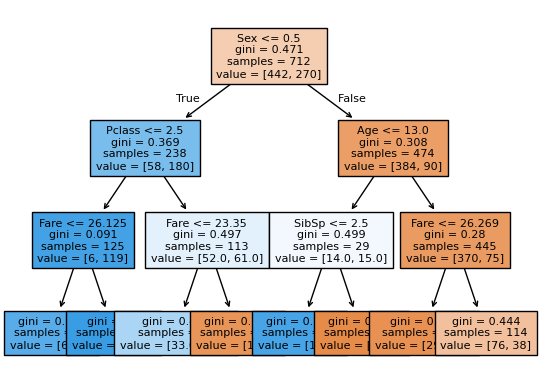

LogisticRegression Logistic regression accuracy: 0.821,  f1:  0.8212290502793296,  AUC:  0.8781152647975078


C:\Users\Антон\AppData\Local\Temp\ipykernel_11880\1967107608.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[i].fillna(mean,inplace= True)
d:\Soft\ProgramFiles\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

y = df_train['Survived']
X = df_train[[ 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]    
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=None)
print(f"{clf.__class__.__name__} accuracy: {accuracy_score(y_test, y_pred):.3f},  f1:  {f1_score(y_test, y_pred, average='micro')},  AUC:  {auc(fpr, tpr) }")

tree.plot_tree(clf, feature_names=list(X),max_depth=4,               
               fontsize=8,
               filled = True)
plt.show()

for i in df_train:
    mean = df_train[i].mean()
    df_train[i].fillna(mean,inplace= True)
y = df_train['Survived']
X = df_train[[ 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)    
# Сравним решение деревом с решением логистической регрессией:
clf_log = LogisticRegression()
clf_log.fit(X_train, y_train)
y_pred = clf_log.predict(X_test)
y_score = clf_log.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=None)
print(f"{clf_log.__class__.__name__} Logistic regression accuracy: {accuracy_score(y_test, y_pred):.3f},  f1:  {f1_score(y_test, y_pred, average='micro')},  AUC:  {auc(fpr, tpr) }")


Подберем лучшие параметры для дерева поиска при помощи GridSearchCV:

In [68]:
def perform_grid_search(model, param_grid, X_train = X_train, y_train = y_train, X_test=X_test, y_test=y_test, scoring='f1', cv=4, verbose=0,threshold = None):
  
    # Настройка GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=verbose,
        n_jobs=-1
    )
    
    # Запуск поиска по сетке
    grid_search.fit(X_train, y_train)
    
    # Результаты поиска
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print("Лучшие параметры:", best_params)    
    
    if X_test is not None and y_test is not None:
        y_pred = best_model.predict(X_test)
        
        if threshold: 
            y_pred_proba = y_pred
            y_pred = (y_pred > threshold).astype(int) # Преобразуем вероятности в классы
        else:
            y_pred_proba = best_model.predict_proba(X_test)[:, 1] # Получаем вероятности используя метод модели

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        }
        
        print("\nРезультаты на тестовой выборке:")
        print(f"Accuracy: {metrics['accuracy']}")
        print(f"F1-score: {metrics['f1']}")
        print(f"ROC AUC: {metrics['roc_auc']}")


param_grid_search_tree = [   
    
    {
        'criterion': ['gini', 'entropy'],
        'splitter' :['best'],
        'max_depth': [3,4,5,6]        
    }
]
perform_grid_search(DecisionTreeClassifier(), param_grid_search_tree)

Лучшие параметры: {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}

Результаты на тестовой выборке:
Accuracy: 0.8268156424581006
F1-score: 0.7801418439716312
ROC AUC: 0.8801272066458982


При помощи Cross_Val_Score найдем, при каком разделении выборки найдется самое точное решение:

In [69]:
means = {}
stds = []
for i in range(1, 15):
    md = cross_val_score(DecisionTreeClassifier(max_depth=i), X, y, cv = 5, scoring = 'roc_auc_ovo_weighted' )    
    means[i]=md.mean()
    stds.append(md.std())
print((means))
print("Maximum value is: ",max((means.values())))

{1: 0.7668182422550192, 2: 0.8077195990264692, 3: 0.8438129422998848, 4: 0.84373688253994, 5: 0.8454506206152184, 6: 0.8404325180048448, 7: 0.8060615268336004, 8: 0.7894271636565566, 9: 0.7947018704134662, 10: 0.7846169424364009, 11: 0.7648484688504984, 12: 0.7707220477849188, 13: 0.7626051903156011, 14: 0.7646186080045392}
Maximum value is:  0.8454506206152184


#
Вывод: начиная с глубины равной 3 точность растет слабо, а с 7 начинает падать. Возможно из за переобучения.

[0.128 0.646 0.042 0.0683 0 0.116 0]


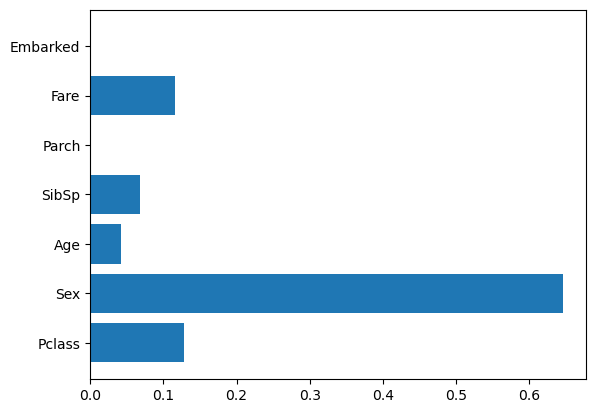

In [70]:
print(clf.feature_importances_)
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns)
plt.show()

Вывод: По этому графику можно сделать вывод, что главная фича, это пол. Далее идет класс билета и цена что скорее всего является одним и тем же.  
А раз главная фича это пол, узнаем, сколько было женщин и мужчин на корабле.

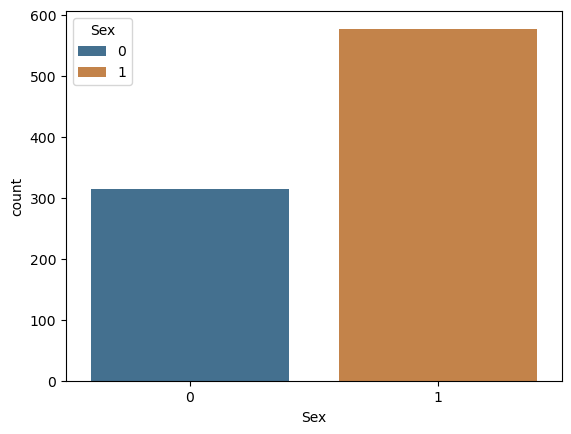

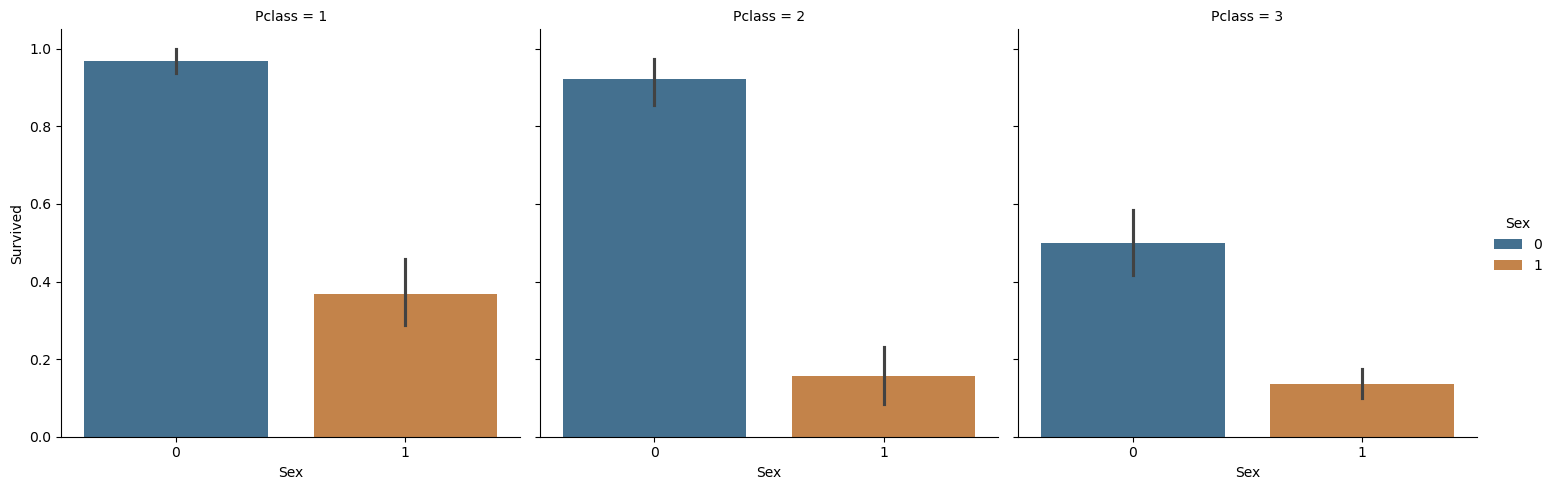

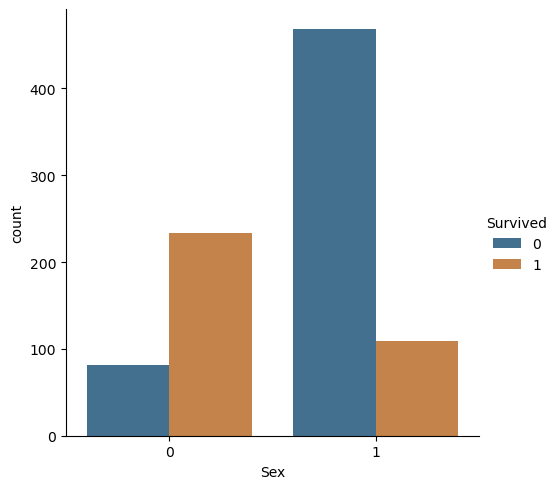

In [71]:
sns.countplot(data = df_train,x='Sex',            
            hue='Sex',
            saturation=0.5)



sns.color_palette("pastel")
sns.catplot(data = df_train,y='Survived',x='Sex',
            col='Pclass',
            hue='Sex',
            kind='bar', saturation=0.5)
sns.catplot(data = df_train,hue = 'Survived', x = 'Sex',
            kind='count', saturation=0.5)
plt.show()

1 й график. Мы видим что количество мужчин почти в 2 раза больше чем женщин.
2 й график. Мы видим, что больше всего процент выживаемости у женщин в первом классе. Если говорить о мужчинах, то первый и второй класс заметно выживет больше, чем третий.

3 й график. Большая часть женщин была спасена. Т.е предположу что спасали всех женщин, кого видели.

Разберем, каких мужчин спасали:

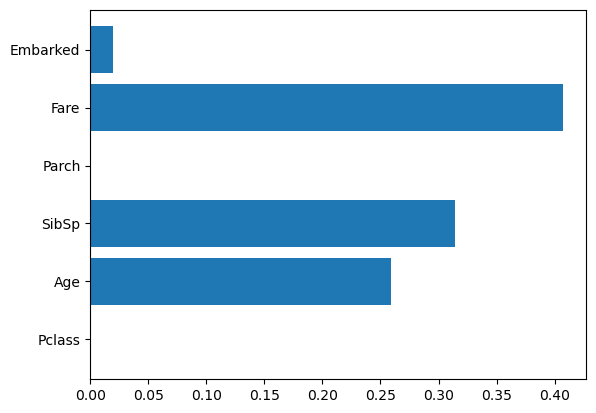

In [72]:
df_man= df_train[df_train['Sex']==1]
len(df_man)

y = df_man['Survived']
X = df_man[[ 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']]

#df = pd.concat([X,y], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns)
plt.show()

Мы видим, что среди мужчин в первую очередь повлияла стоимость билета. Далее идут количество братьев/сестер.

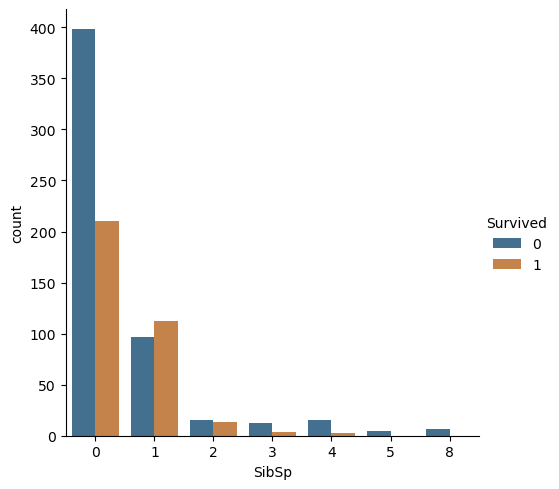

In [73]:

sns.catplot(data = df_train,hue = 'Survived', 
            x = 'SibSp',kind='count', saturation=0.5)
plt.show()

Вывод: больше шансов спастись у тех, у кого 1 брат/сестра. 

Далее посмотрим статистику по родителям/детям:

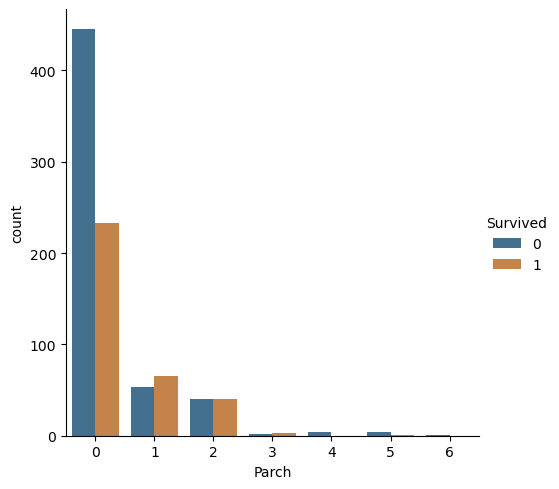

In [75]:
sns.catplot(data = df_train,hue = 'Survived', 
            x = 'Parch',kind='count', saturation=0.5)
plt.show()

Вывод: больше шансов спастись у тех, у кого 1-3 родителей/детей. 

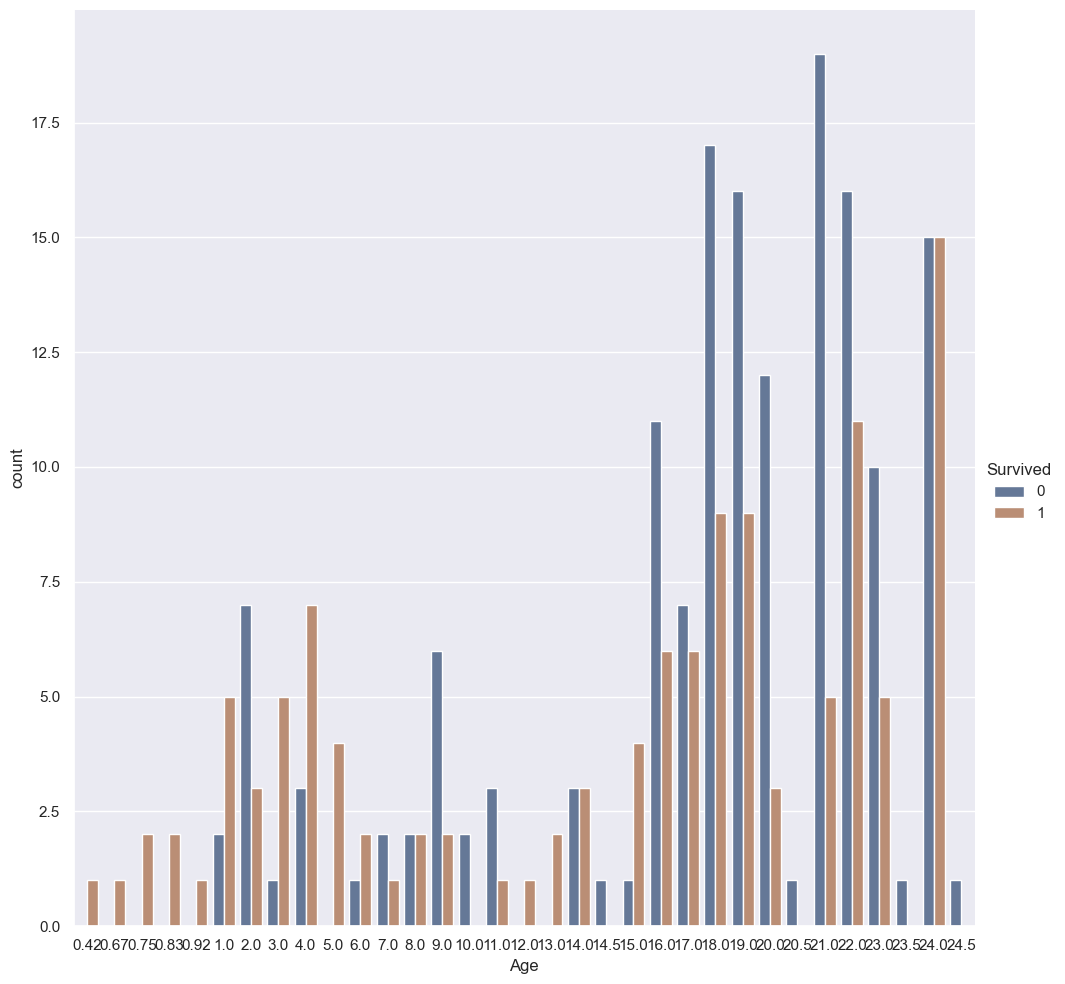

In [101]:

sns.catplot(data = df_train[df_train['Age']<25],hue = 'Survived', 
            x = 'Age',kind='count', saturation=0.5, height = 10)
#plt.figure(figsize=(12,6))

plt.show()

Здесь мы видим, что спасенные дети в основном до 15 лет. Возможно было соответствующее правило.

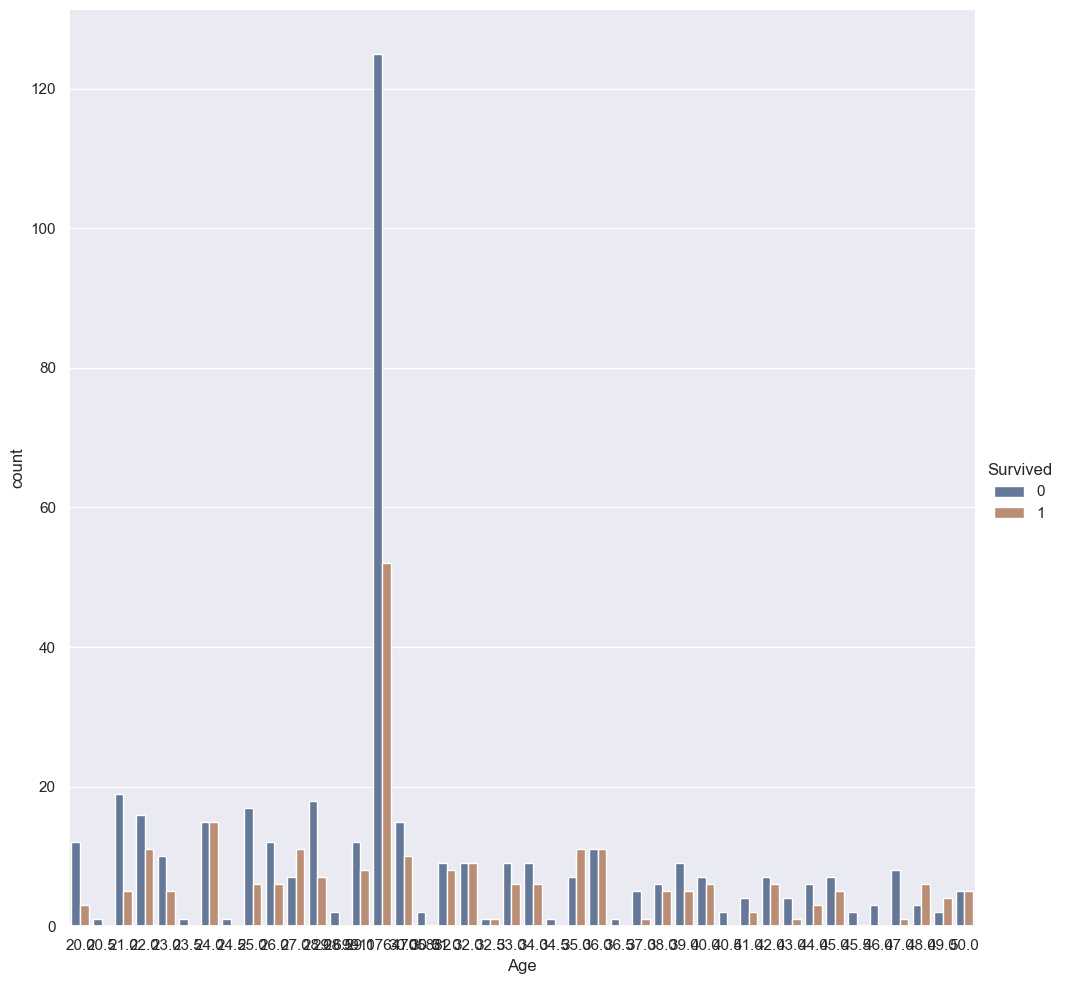

In [100]:
sns.catplot(data = df_train[df_train['Age'].between(20,50)],hue = 'Survived', 
            x = 'Age',kind='count', saturation=0.5, height = 10)
plt.show()

Вывод: в среднем возрасте нет зависимости спасшихся от возраста. Значение 29.69  - среднее значение, которым заменены пробелы.

Общий вывод: В первую очередь спасались женщины и дети до 15 лет. Также есть небольшая зависимость от стоимости билета, владельцы более дорогих билетов умудрялись спасалиться чаще. 